In [1]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
import pulser.waveforms as waveforms

In [2]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import qutip
import scipy

# 1. Layer-based sequences

We shall implement a version of Variational Quantum Simulation, following https://arxiv.org/pdf/1810.03421 .

First we set up our atom array

In [3]:
# Atom Register
N = 3
M = 3
reg = Register.rectangle(N, M, spacing=4.9,prefix='atom')
#reg.draw() 

Next, we select our device and we declare the channels that we will be using

In [4]:
device = Chadoq2(reg.qubits)
seq = Sequence(device) # Resets if called again
seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms
pprint(seq.declared_channels)

{'ryd': Rydberg.Global(Max Absolute Detuning: 50 MHz, Max Amplitude: 2.5 MHz, Basis: 'ground-rydberg')}


Create the layers of the circuit as pulse sequences

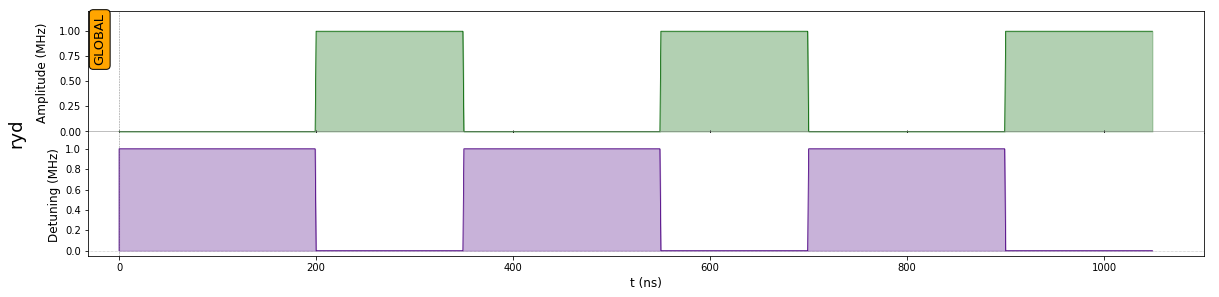

In [5]:
layers = 3

cost = Pulse.ConstantPulse(150, 1, 0, 0)
mix = Pulse.ConstantPulse(200, 0, 1, 0)

for _ in range(layers):
    seq.add(mix, 'ryd')
    seq.add(cost, 'ryd')

seq.draw()

# 2. Emulating one run of the sequence

First we create the Qobjs that represent the Quantum Resource

In [6]:
# Global variable for generating tensor product of identities
ones = [qutip.qeye(2) for _ in range(N*M)]

#Functions to Define Operators
def local_operator(qubit_id,operator):
    """
    Returns a local gate at a qubit
    """
    temp = [qutip.qeye(2) for _ in range(N*M)]
    pos =  reg._ids.index(qubit_id)
    temp[pos] = operator
    return qutip.tensor(temp)

def two_body_operator(qubit_id1, qubit_id2, operator):
    """
    Returns a local gate at a qubit
    """
    if qubit_id1 == qubit_id2:
        raise ValueError("Same Atom ID given for a Two-body operator")

    temp = [qutip.qeye(2) for _ in range(N*M)]
    pos1 =  reg._ids.index(qubit_id1)
    pos2 =  reg._ids.index(qubit_id2)
    temp[pos1] = operator
    temp[pos2] = operator
    
    return qutip.tensor(temp)

We now construct the Hamiltonian

In [7]:
# Sum of sigma x:
H_X = 0 # Time-dependent
for qubit in reg.qubits:
    H_X += local_operator(qubit,qutip.sigmax())
    
# Sum of occupations:
occup = 0.5*(qutip.sigmaz()+1)
H_N = 0 # Time-dependent
for qubit in reg.qubits:
    H_N -= local_operator(qubit, occup)
    
# Sum of Neighbors:
H_NN = 0 # Time-independent
C6 = 1e5

import itertools
for qubit1,qubit2 in itertools.combinations(reg._ids,2):
    R = np.sqrt(np.sum((reg.qubits[qubit1]-reg.qubits[qubit2])**2))
    coupling = C6/R**6
    H_NN += coupling * two_body_operator(qubit1,qubit2,occup)

    print(qubit1,qubit2, coupling)

atom0 atom1 7.224761580900886
atom0 atom2 0.11288689970157634
atom0 atom3 7.224761580900886
atom0 atom4 0.9030951976126107
atom0 atom5 0.057798092647207075
atom0 atom6 0.11288689970157634
atom0 atom7 0.057798092647207075
atom0 atom8 0.014110862462697042
atom1 atom2 7.224761580900886
atom1 atom3 0.9030951976126107
atom1 atom4 7.224761580900886
atom1 atom5 0.9030951976126107
atom1 atom6 0.057798092647207075
atom1 atom7 0.11288689970157634
atom1 atom8 0.057798092647207075
atom2 atom3 0.057798092647207075
atom2 atom4 0.9030951976126107
atom2 atom5 7.224761580900886
atom2 atom6 0.014110862462697042
atom2 atom7 0.057798092647207075
atom2 atom8 0.11288689970157634
atom3 atom4 7.224761580900886
atom3 atom5 0.11288689970157634
atom3 atom6 7.224761580900886
atom3 atom7 0.9030951976126107
atom3 atom8 0.057798092647207075
atom4 atom5 7.224761580900886
atom4 atom6 0.9030951976126107
atom4 atom7 7.224761580900886
atom4 atom8 0.9030951976126107
atom5 atom6 0.057798092647207075
atom5 atom7 0.903095197

Now we want to extract the contents of the sequences into the qubits, as instructions for emulation in qutip

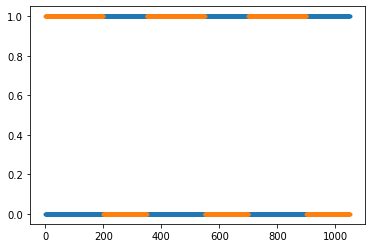

In [8]:
# Get Rabi freq and detuning samples from all sequence

amp = []
det = []
for x in seq._schedule['ryd']:
    obj = x.type
    if type(obj) == Pulse:
        for t in range(obj.duration): 
            amp.append(obj.amplitude.samples[t])
            det.append(obj.detuning.samples[t])

plt.plot(range(len(amp)),amp,'.')
plt.plot(range(len(det)),det,'.')

We define a function to find the k-nearest neighbors, which we can then use as a template to search for atoms inside a Rydberg Blockade radius, for example.

In [9]:
coordinates = list(reg.qubits.values())
nn = scipy.spatial.KDTree(coordinates)

def get_nn(q):
    distances, indexes = nn.query(reg.qubits[q],k=5)
    ans=[]
    for i in range(len(indexes)):
        if distances[i] == min(distances[1:]): #can be modified for different 'neighbor' defs
            ans.append([reg._ids[indexes[i]],distances[i]])
    return ans

In a rectangular array, inner atoms have four nearest neighbors:

In [10]:
get_nn('atom4')

[['atom1', 4.9], ['atom3', 4.9], ['atom5', 4.9], ['atom7', 4.9]]

Define an observable

In [11]:
#Observable and Initial State
#observable = local_operator("q1",'occup') + two_body_operator('q1','q3','occup')
psi0 = qutip.tensor([qutip.basis(2, 0) for _ in range(N*M)]) # all up

# Observable (usually diagonal)
observable = 0
for qubit in reg.qubits:
    observable += local_operator(qubit,occup)

for qubit1 in reg.qubits:
    for qubit2, R in get_nn(qubit1):
        observable += two_body_operator(qubit1,qubit2,occup)
        

Choose an initial state

In [12]:
# Initial State 
# all_down = [qutip.basis(2,1) for _ in range(N*M)]

# Initial State ("all_plus")
plus = (1/np.sqrt(2))*(qutip.basis(2,0)+qutip.basis(2,1))
psi0 = qutip.tensor([plus for _ in range(N*M)])

Time-evolve using QuTiP

In [13]:
# Callables for time evolution
def omega (t,args):
    return amp[int(t)]

def delta (t,args):
    return det[int(t)]

H = [H_NN, [H_N, delta], [H_X, omega]]

total_duration = max([seq._last(ch).tf for ch in seq._schedule])


In [14]:
output = qutip.sesolve(H, psi0, range(total_duration),[observable]) #Evaluate observable in the evolved state

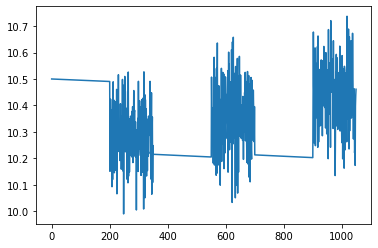

In [15]:
plt.plot(range(total_duration),output.expect[0])

# Putting Everything into a function

We want to parametrize this routine. Define atom array:

In [16]:
# Atom Register
N = 1
M = 4
reg = Register.rectangle(N, M, spacing=6.1,prefix='atom')
#reg.draw() 
device = Chadoq2(reg.qubits)

In [17]:
coordinates = list(reg.qubits.values())
nn = scipy.spatial.KDTree(coordinates)

def get_nn(q):
    distances, indexes = nn.query(reg.qubits[q],k=5)
    ans=[]
    for i in range(len(indexes)):
        if distances[i] == min(distances[1:]): #can be modified for different 'neighbor' defs
            ans.append([reg._ids[indexes[i]],distances[i]])
    return ans

In [18]:
get_nn('atom3')

[['atom2', 6.099999999999998]]

In [19]:
#Observable and Initial State

# Observable (usually diagonal)
observable = 0
for qubit in reg.qubits:
    observable += local_operator(qubit,occup)

for qubit1 in reg.qubits:
    for qubit2, R in get_nn(qubit1):
        observable += 3*two_body_operator(qubit1,qubit2,occup)

# Initial State ("all_plus")
plus = (1/np.sqrt(2))*(qutip.basis(2,0)+qutip.basis(2,1))
psi0 = qutip.tensor([plus for _ in range(N*M)])

Build Resource Hamiltonian:

\begin{align}
\mathcal H_R = \Omega(t) \sum_i \sigma_i^x + \delta(t) \sum_i n_i + \sum_{i<j} \frac{C_6}{R_{ij}^6} n_in_j
\end{align}

Detuning drives (diagonal) evolution that commutes with Z. Amplitude drives non-commuting (mixing) evolution

Define a Cost Function

In [20]:
# Sequence based on Constant Pulses and variable durations
evol = lambda duration: Pulse.ConstantPulse(duration, 0, 4, 0)
mix = lambda duration: Pulse.ConstantPulse(duration, 0.2, 0, 0)

def build_sequence(params,layers=1,draw=False):
    seq = Sequence(device) # Resets sequence every time its called
    seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms

    for p in range(layers):
        seq.add(evol(params[0][p]), 'ryd') #amplitude
        seq.add(mix(params[1][p]), 'ryd') #detuning    
        
    if draw: seq.draw()
    
    amp = []
    det = []
    
    #Get pulse sequence
    for x in seq._schedule['ryd']:
        block = x.type
        if type(block) == Pulse:
            for t in range(block.duration): # Add samples 
                amp.append(block.amplitude.samples[t])
                det.append(block.detuning.samples[t])
                
    return amp,det

In [21]:
def build_hamiltonian(reg):
    # Sum of sigma x:
    H_X = 0 # Time-dependent (Rabi Frequency)
    H_N = 0 # Time-dependent (Detuning)
    VdW = 0 # Time-independent (Van der Waals)
    C6 = 1e6

    for qubit in reg.qubits:
        H_X += local_operator(qubit,qutip.sigmax())
        H_N -= local_operator(qubit,occup) # Notice the minus sign (bias towards all up)
        for qubit2 in reg._ids[reg._ids.index(qubit)+1::]:
            R = np.sqrt(np.sum((reg.qubits[qubit]-reg.qubits[qubit2])**2))
            coupling = C6/R**6
            VdW += coupling * two_body_operator(qubit,qubit2,occup)
            
    return VdW, H_N, H_X

In [22]:
def cost_function(params,layers=1,draw=False):

    amp, det = build_sequence(params,layers,draw)
    
    # Callables for time evolution
    delta = lambda t,args: det[int(t)]
    omega = lambda t,args: amp[int(t)]

    VdW, H_N, H_X = build_hamiltonian(reg)
    H = [VdW, [H_N, delta], [H_X, omega]]
    tlist = range(len(amp))

    output = qutip.sesolve(H, psi0 , tlist, [observable])
    return(output.expect[0][-1]) #return final (in time) expectation value

Test some layers with random durations:

[[75 54]
 [87 78]]


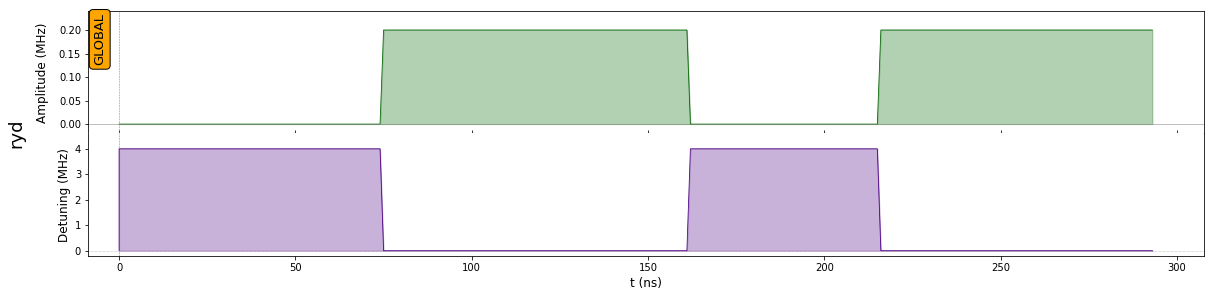

5.623826960873362


In [23]:
np.random.seed(5)

params = np.random.randint(40,100,size=(2,2))

print(params)
print(cost_function(params,layers=2,draw=True))

Check some parameter space at depth 1:

Elapsed time: 64.70551705360413


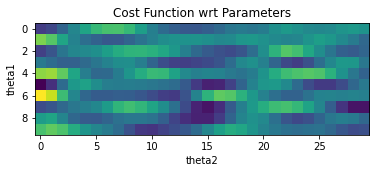

In [24]:
import time

param_space = [np.arange(10,20),np.arange(10,40)]
results = np.zeros((len(param_space[0]),len(param_space[1])))

start = time.time()
for j,theta1 in enumerate(param_space[0]):
    for k,theta2 in enumerate(param_space[1]):
        params = [[theta1],[theta2]]
        results[j,k] = cost_function(params)
        #print(params, results[theta1,theta2])
print(f'Elapsed time: {time.time()-start}')
        
plt.ylabel('theta1')
plt.xlabel('theta2')
plt.title('Cost Function wrt Parameters')
plt.imshow(results);

Optimize Parameters in a proper region (using scipy minimize)